In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
import sklearn
sklearn.set_config(transform_output="pandas")
from sklearn.utils import compute_sample_weight
#
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import RobustScaler

from sklearn.cluster import KMeans

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

import optuna

import mlflow

import warnings

warnings.simplefilter('ignore')

import joblib

from joblib import dump, load

import requests

client = mlflow.MlflowClient(tracking_uri="http://127.0.0.1:8082")

mlflow.set_tracking_uri("http://127.0.0.1:8082")

import requests

from sklearn import impute

from sklearn.impute import KNNImputer

from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer

from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline

In [2]:
data = pd.read_csv("train.csv")

In [3]:
y = data['income_>50K']

In [4]:
X = data.drop(['income_>50K'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

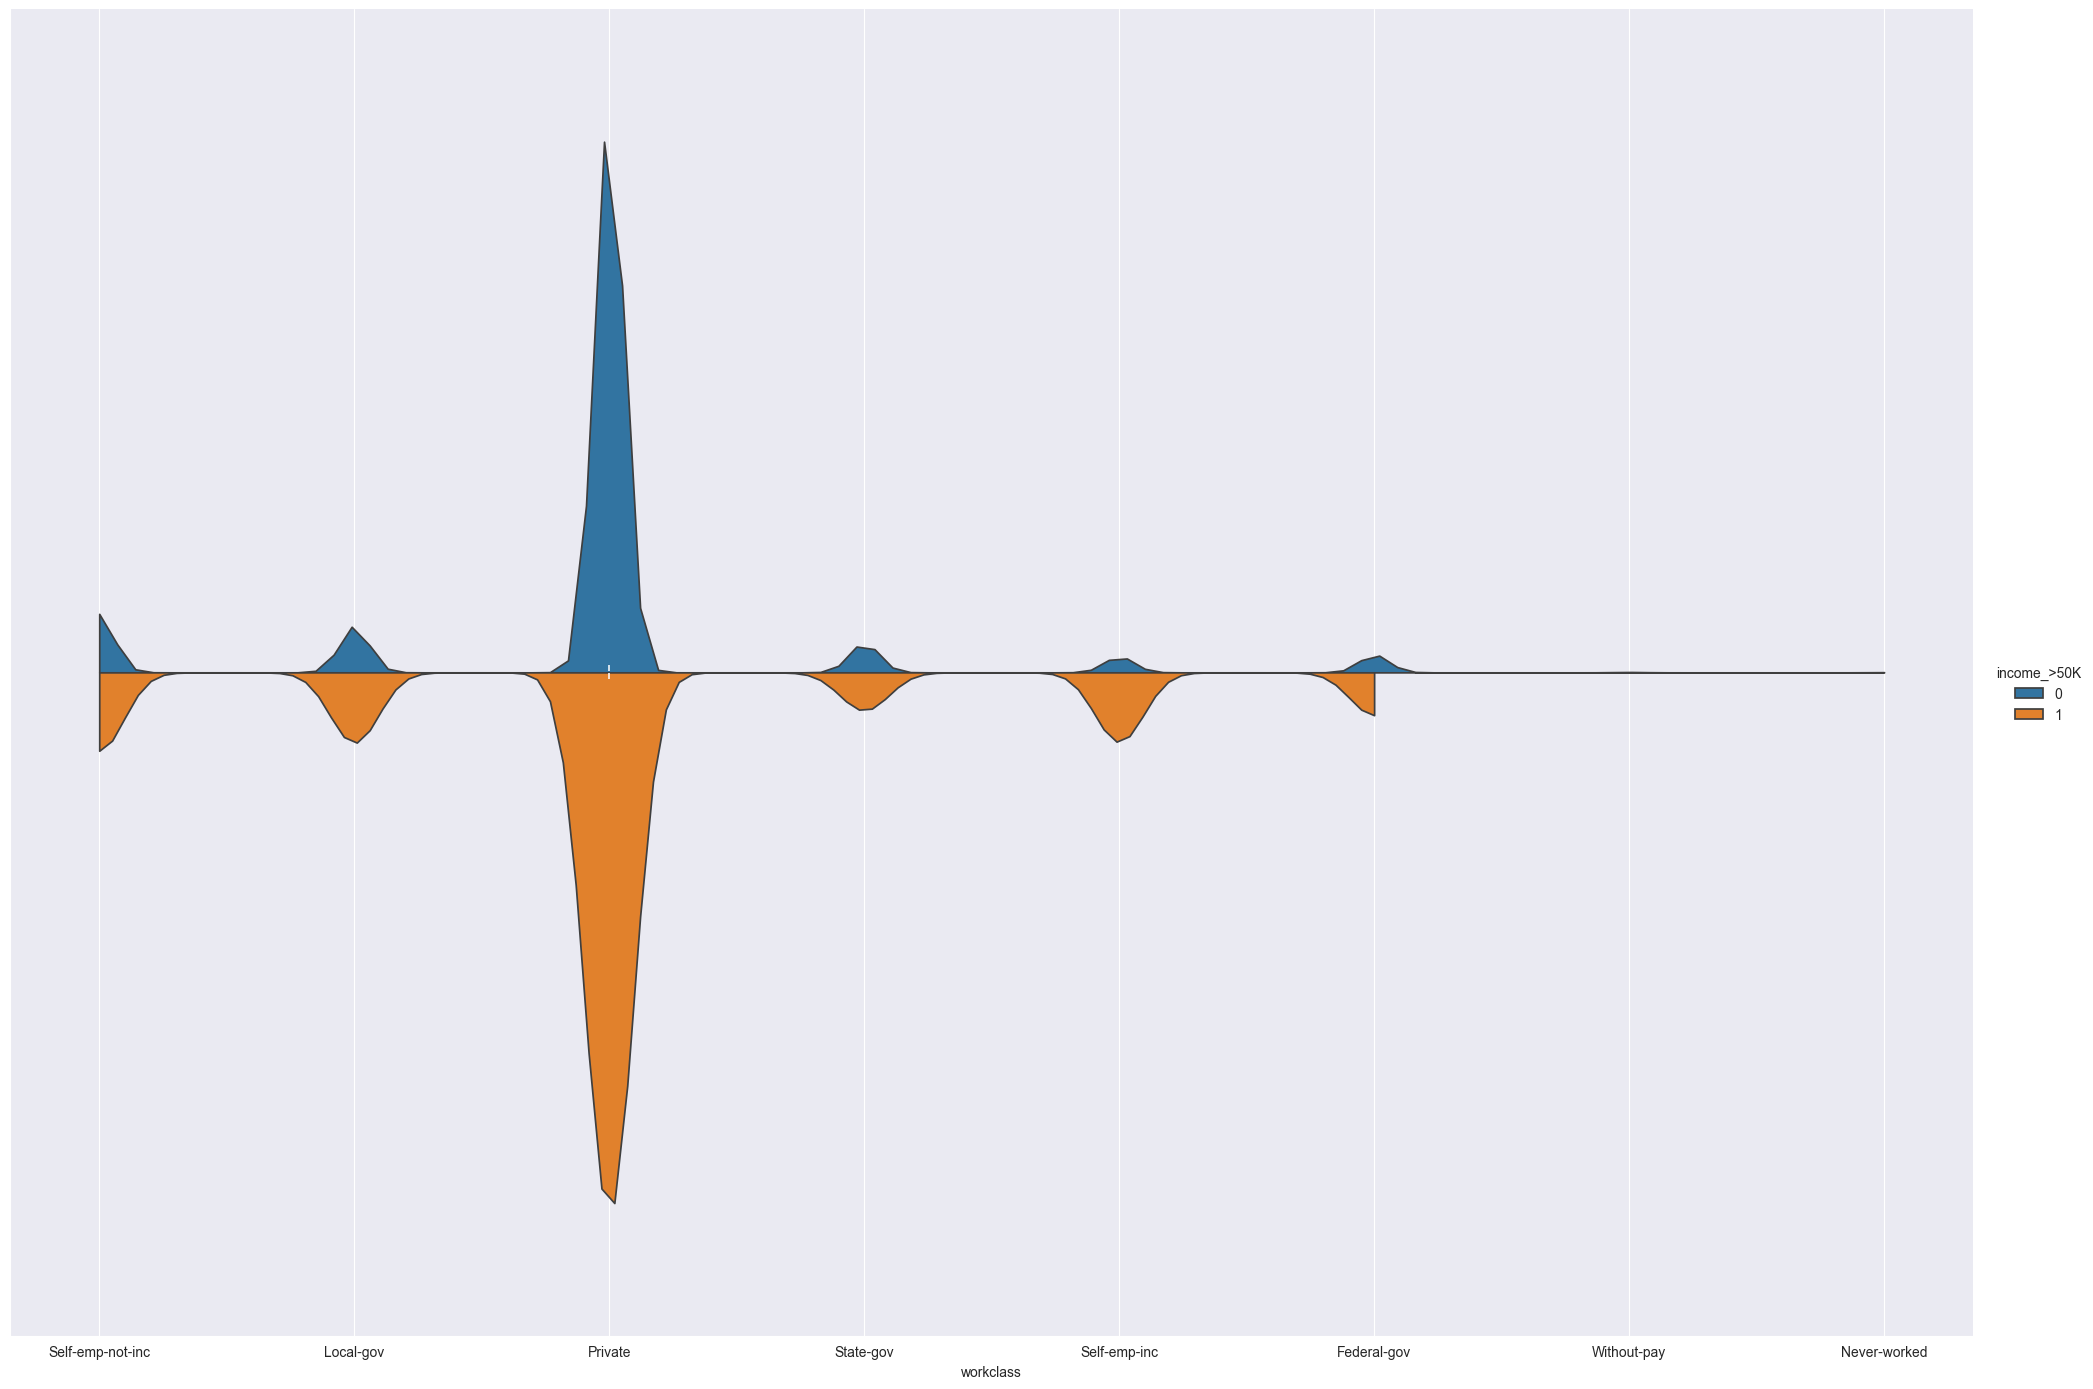

In [6]:
df_for_sns = pd.concat([X_train,pd.DataFrame(y_train)], axis=1)
sns.catplot(
    data=df_for_sns, hue="income_>50K", x="workclass",
    kind="violin", bw_adjust=.5, cut=0, split=True, height=14, aspect=20/14
)

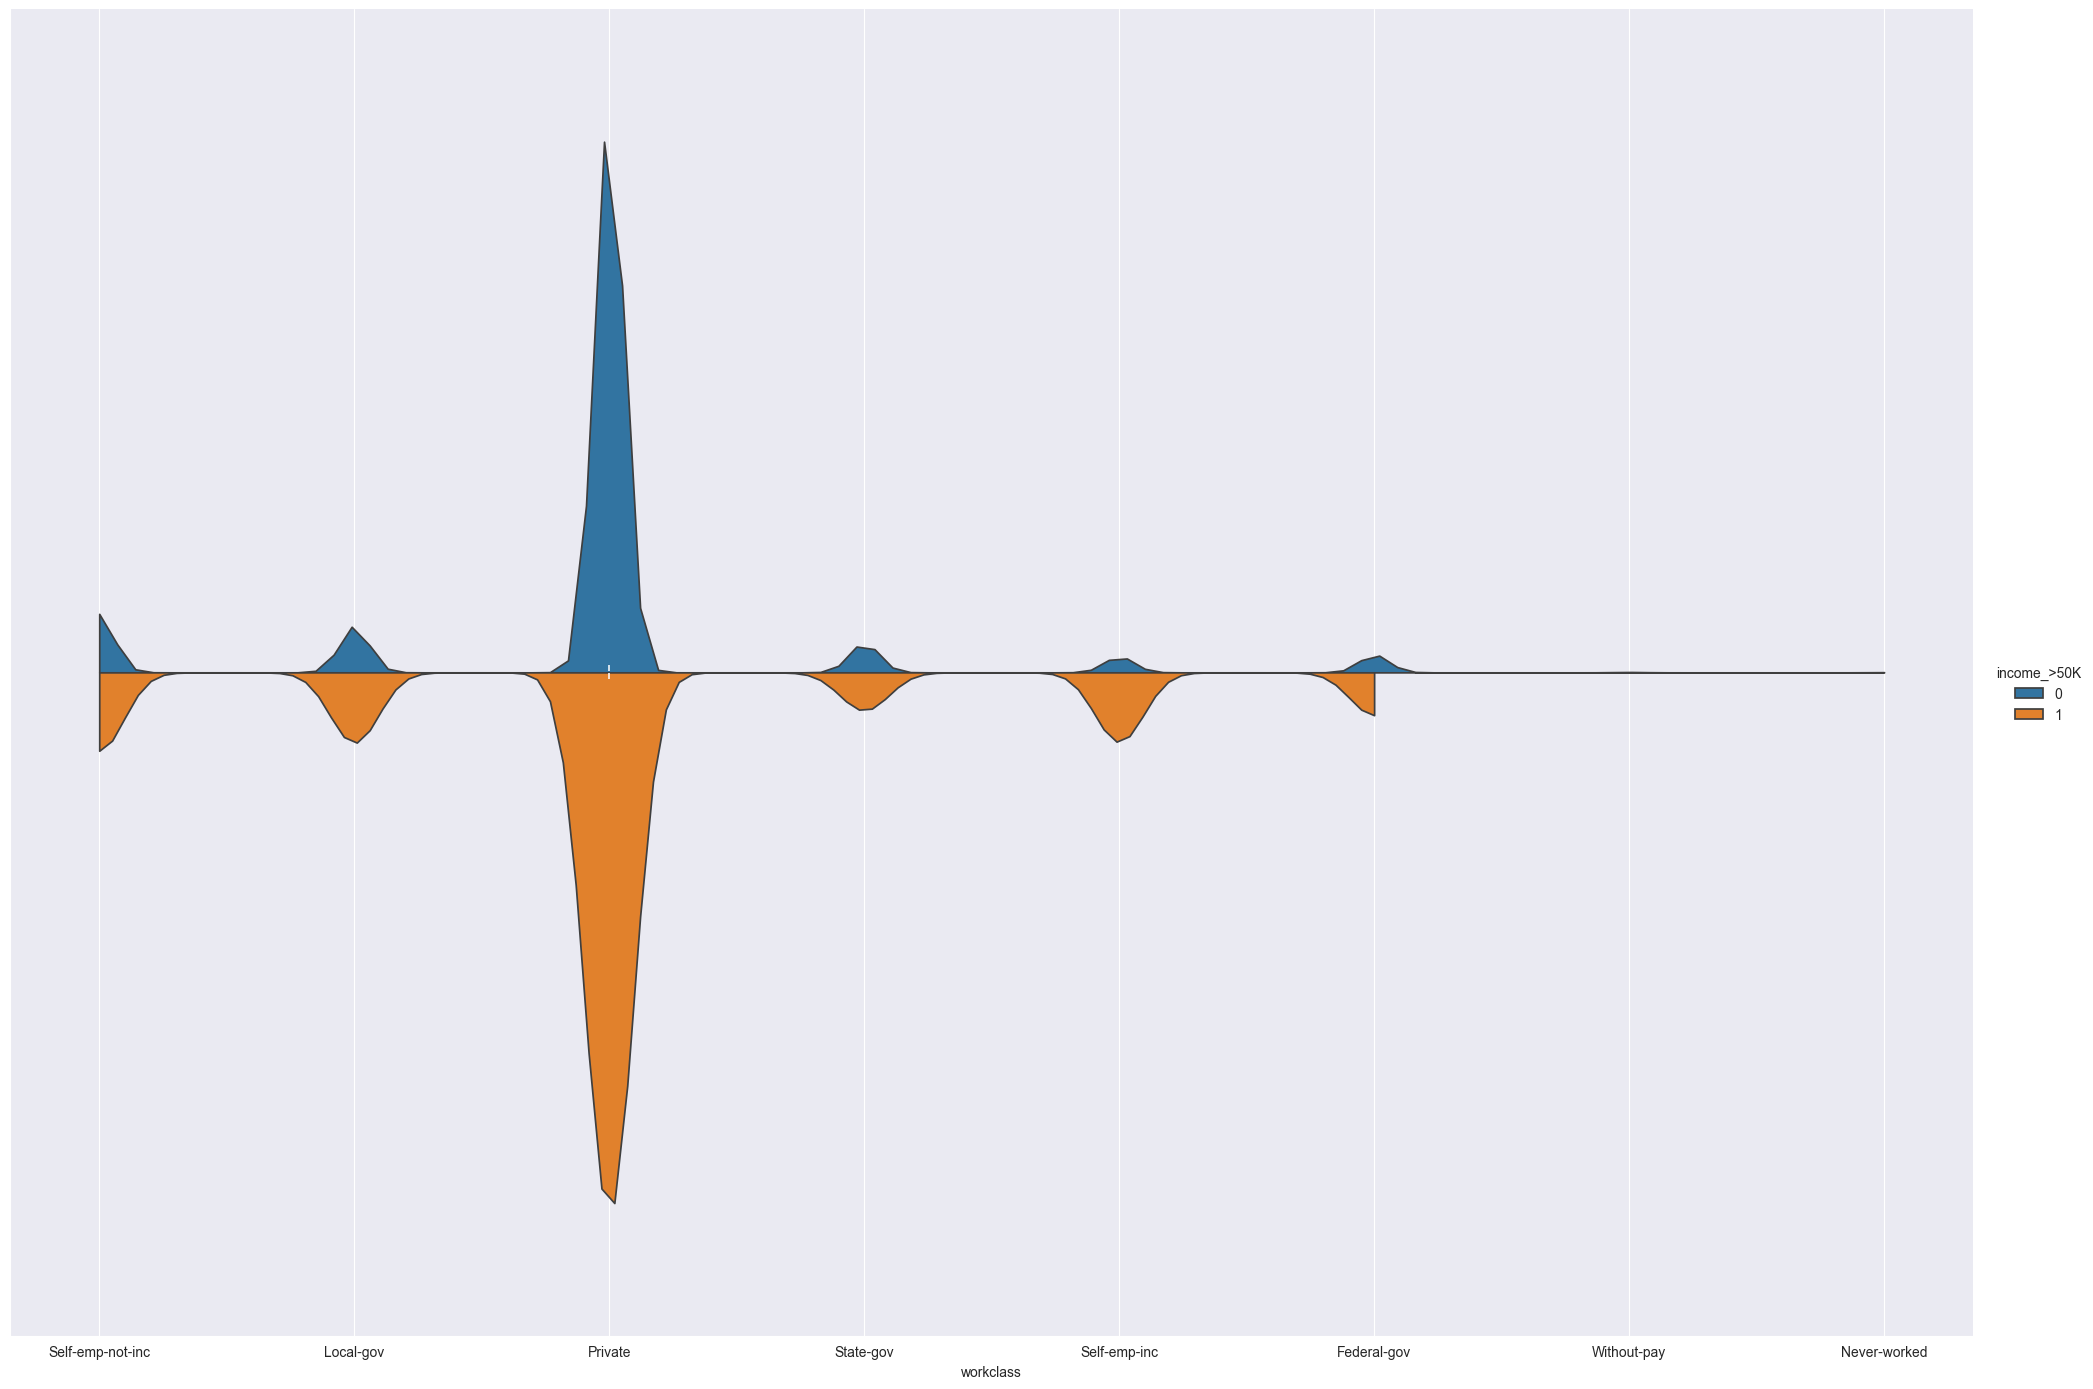

In [8]:
# violin hist after smote
df_for_sns = pd.concat([X_train,pd.DataFrame(y_train)], axis=1)
sns.catplot(
    data=df_for_sns, hue="income_>50K", x="workclass",
    kind="violin", bw_adjust=.5, cut=0, split=True, height=14, aspect=20/14
)

In [9]:
num_columns = list(X_train.select_dtypes(exclude=['object']).columns)
num_columns

['age',
 'fnlwgt',
 'educational-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [10]:
cat_columns = list(X_train.select_dtypes(include=['object']).columns)

In [11]:

numerical = Pipeline(steps=[
    ("simple_imputer", SimpleImputer()),
    ("SMOTE", SMOTE()),
    ('Scaler', StandardScaler())
])

categorical = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy='constant')),
    ("OneHotEncoder", OneHotEncoder(handle_unknown='ignore', #drop=['first', 'if_binary'],
                                    sparse_output=False))
])

ct = ColumnTransformer([
    ("numerical", numerical, num_columns),
    ("categorical", categorical, cat_columns)
], remainder = 'passthrough')


pipe = Pipeline(steps=[
    ("ct", ct),
    #("XGBClassifier", XGBClassifier())
])

In [12]:
pipe.fit_resample(X_train, y_train)

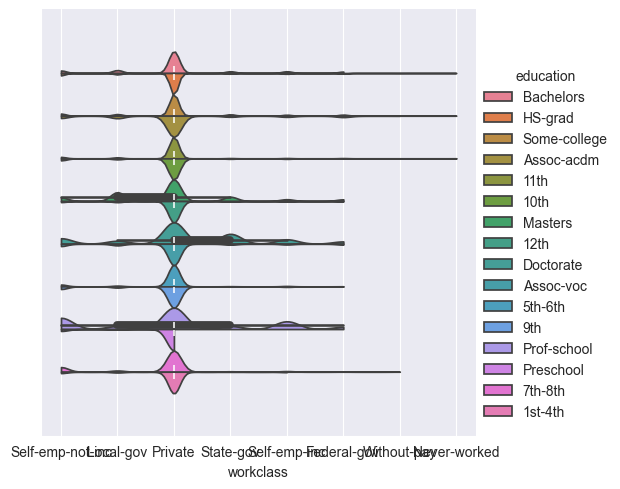

In [13]:
#Change for education
sns.catplot(
    data=X_train, hue="education", x="workclass",
    kind="violin", bw_adjust=.5, cut=0, split=True,
)

In [14]:
X_train

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
1747,42,Self-emp-not-inc,69333,Bachelors,13,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
15212,53,Local-gov,110510,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,50,United-States
42998,28,Private,89813,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Female,0,0,40,United-States
39929,27,Private,190303,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
9325,47,Private,186539,Some-college,10,Married-civ-spouse,Other-service,Husband,White,Male,0,0,10,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28726,25,Private,104097,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,2829,0,60,United-States
30211,31,Private,235389,7th-8th,4,Never-married,Handlers-cleaners,Not-in-family,White,Female,0,0,30,Portugal
21937,41,Private,89226,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40,United-States
5343,54,Private,212960,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,35,United-States


In [15]:
#Added KNNImputer
numerical = Pipeline(steps=[
    ("KNNImputer", KNNImputer()),
    ("simple_imputer", SimpleImputer()),
    #("power_transform", PowerTransformer()),
    ('Scaler', StandardScaler())
])

categorical = Pipeline(steps=[
    ("simple_imputer", SimpleImputer(strategy='constant')),
    ("OneHotEncoder", OneHotEncoder(handle_unknown='ignore', #drop=['first', 'if_binary'],
                                    sparse_output=False))
])

ct = ColumnTransformer([
    ("numerical", numerical, num_columns),
    ("categorical", categorical, cat_columns)
], remainder = 'passthrough')


pipe = Pipeline(steps=[
    ("ct", ct),
    #("XGBClassifier", XGBClassifier())
])

In [16]:

pipe.fit_transform(X_train, y_train)

,numerical__age,numerical__fnlwgt,numerical__educational-num,numerical__capital-gain,numerical__capital-loss,numerical__hours-per-week,categorical__workclass_Federal-gov,categorical__workclass_Local-gov,categorical__workclass_Never-worked,categorical__workclass_Private,...,categorical__native-country_Puerto-Rico,categorical__native-country_Scotland,categorical__native-country_South,categorical__native-country_Taiwan,categorical__native-country_Thailand,categorical__native-country_Trinadad&Tobago,categorical__native-country_United-States,categorical__native-country_Vietnam,categorical__native-country_Yugoslavia,categorical__native-country_missing_value
1747,0.246540,-1.142400,1.140140,-0.143476,-0.219209,0.777866,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15212,1.047403,-0.751881,-0.411566,-0.143476,-0.219209,0.777866,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
42998,-0.772741,-0.948169,-0.411566,-0.143476,-0.219209,-0.033668,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
39929,-0.845547,0.004867,-0.411566,-0.143476,-0.219209,-0.033668,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9325,0.610568,-0.030830,-0.023639,-0.143476,-0.219209,-2.468270,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28726,-0.991158,-0.812701,1.140140,0.231516,-0.219209,1.589400,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
30211,-0.554324,0.432458,-2.351199,-0.143476,-0.219209,-0.845202,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21937,0.173734,-0.953736,-0.411566,-0.143476,-0.219209,-0.033668,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5343,1.120209,0.219743,1.140140,-0.143476,-0.219209,-0.439435,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


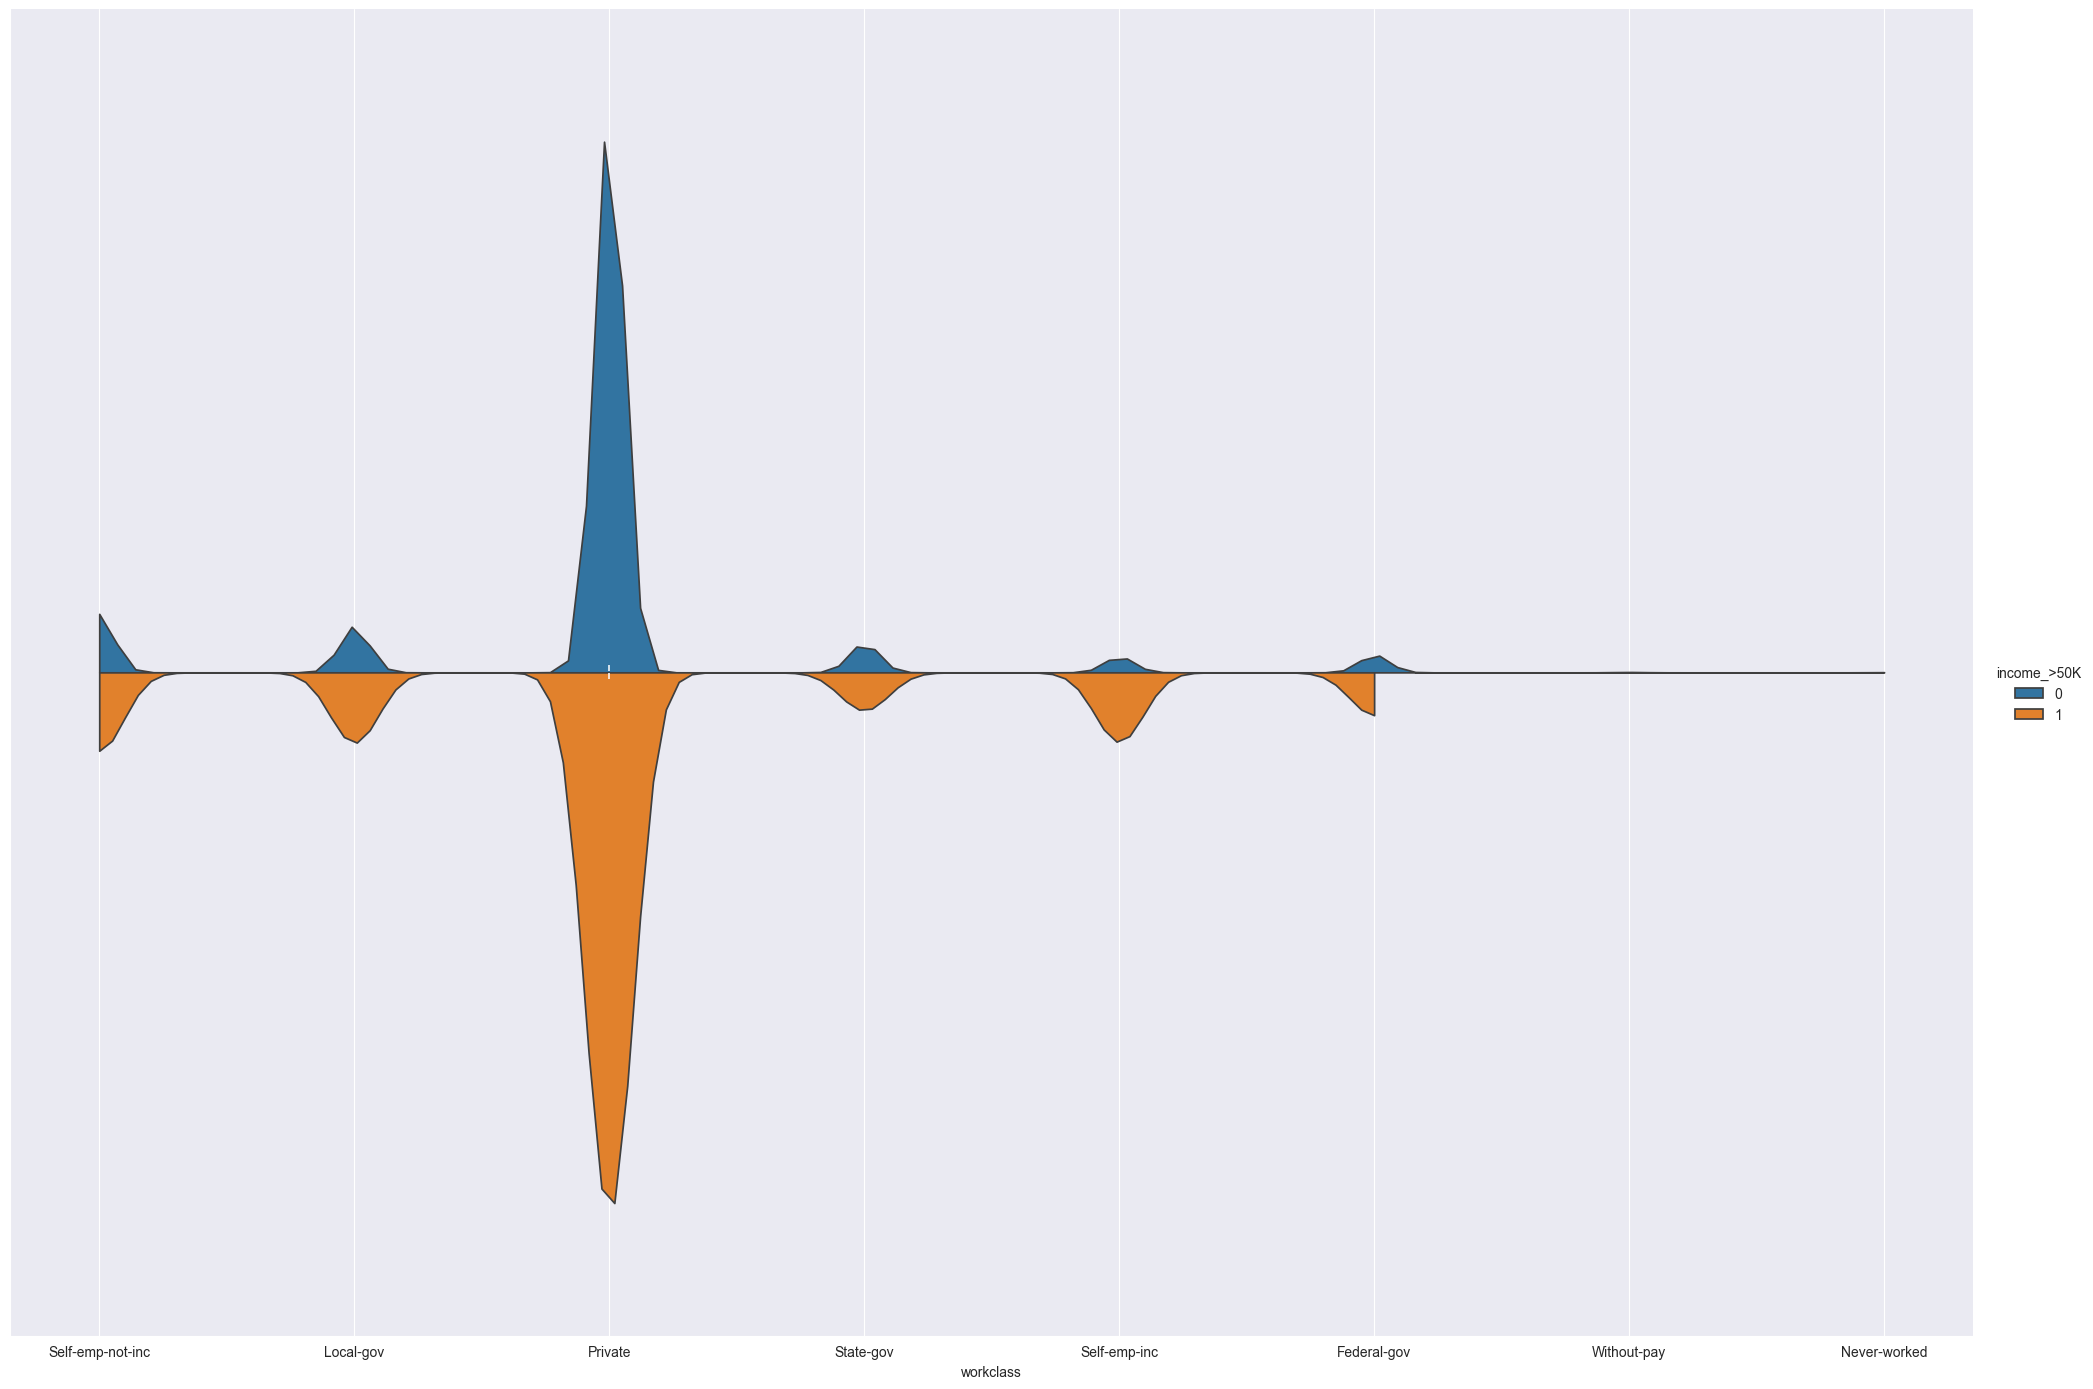

In [17]:
# violin hist after KNN
df_for_sns = pd.concat([X_train,pd.DataFrame(y_train)], axis=1)
sns.catplot(
    data=df_for_sns, hue="income_>50K", x="workclass",
    kind="violin", bw_adjust=.5, cut=0, split=True, height=14, aspect=20/14
)

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'fnlwgt'}>,
        <Axes: title={'center': 'educational-num'}>],
       [<Axes: title={'center': 'capital-gain'}>,
        <Axes: title={'center': 'capital-loss'}>,
        <Axes: title={'center': 'hours-per-week'}>],
       [<Axes: title={'center': 'income_>50K'}>, <Axes: >, <Axes: >]],
      dtype=object)

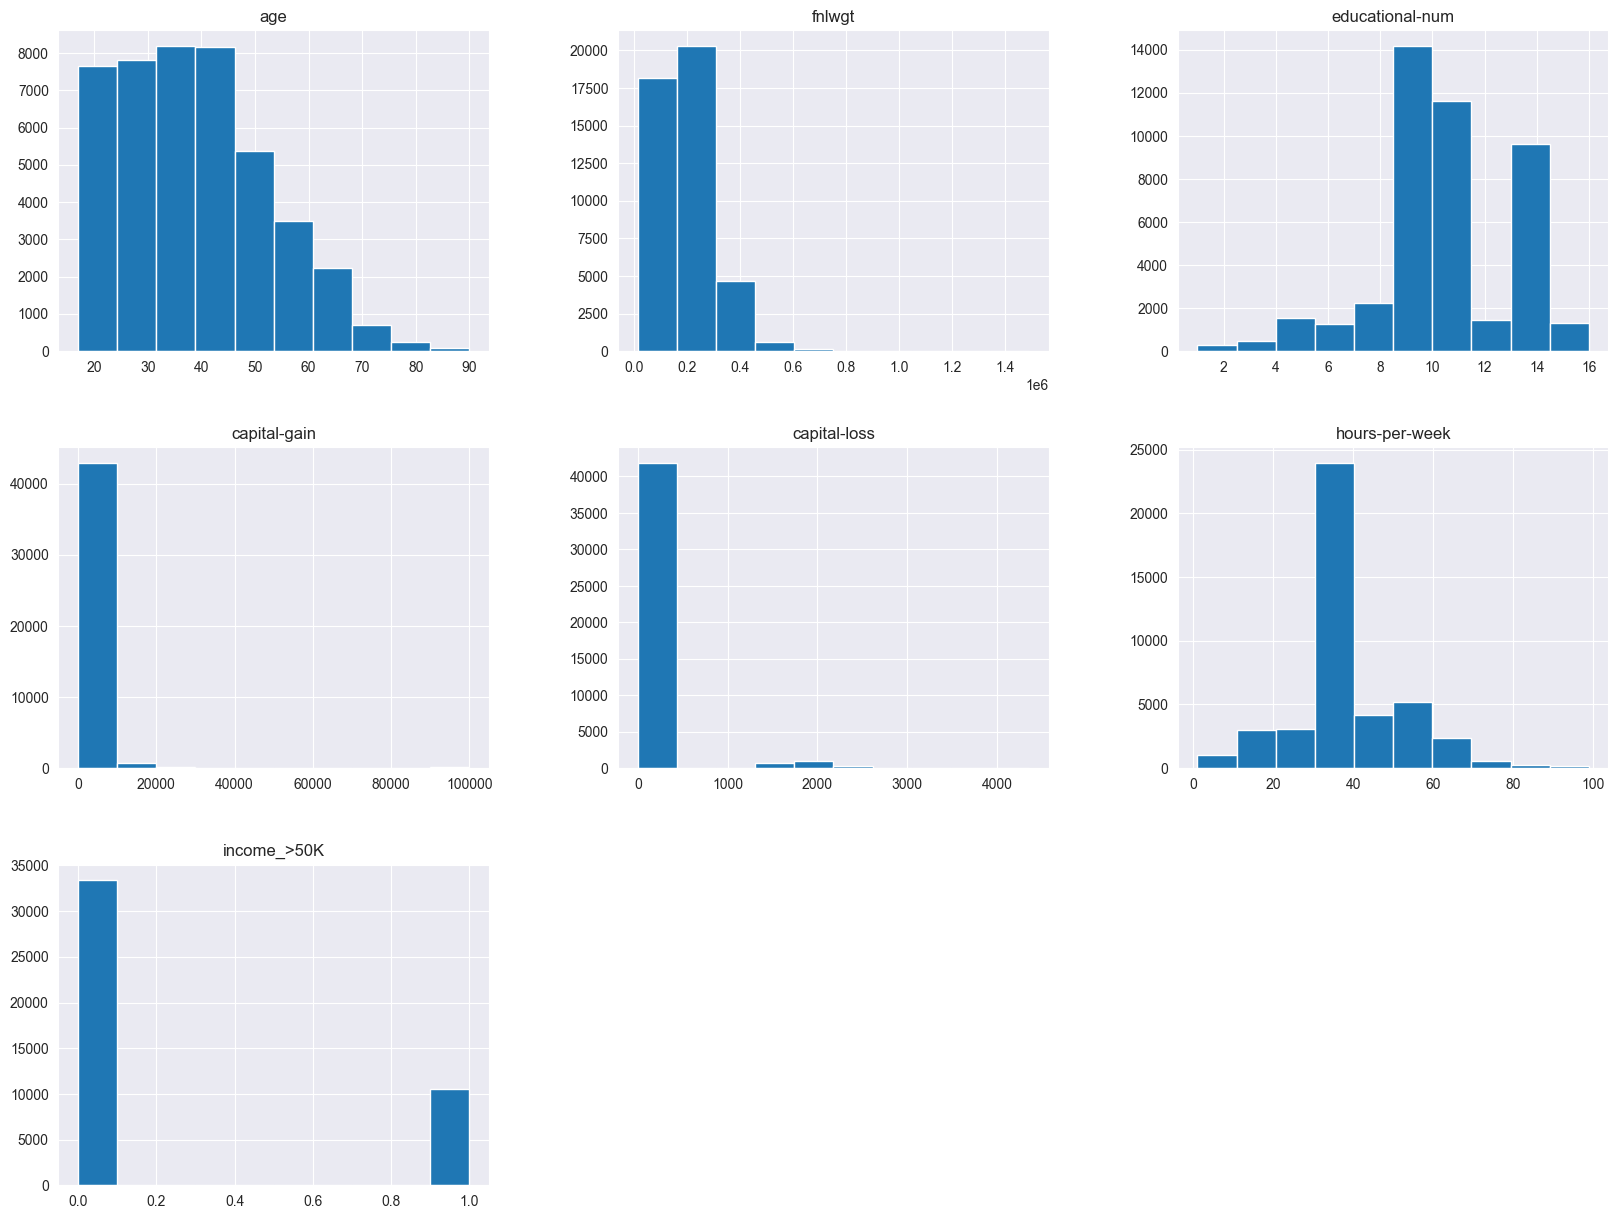

In [18]:
# create hist fo the data
data.hist(figsize=(20,15))

In [20]:
# write a code for KNN using pipline
knn_pipeline = Pipeline(steps=[
    ("ct", ct),
    ("KNNClassifier", KNeighborsClassifier())
])

# Fit the pipeline to the training data
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('KNNImputer',
                                                                   KNNImputer()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer()),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'educational-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('OneHotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'gender',
                                                   'native-country'])])),
                ('KNNClassifier', KNeighborsClassifier())])